# Beer Classifier

Data set: https://www.kaggle.com/nickhould/craft-cans

This notebook is a study of the data from the above source to first visualize, and then train a classifier to distinguish between different styles of beer.

In [1]:
# aesthetic
import warnings
warnings.filterwarnings('ignore')

# reproducability
import random
seed = 1234
random.seed(seed)

# import necessary packages/functions
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import model_selection
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import History
history = History() # allows to plot accuracy/loss vs epochs

Using TensorFlow backend.


In [2]:
# importing data
beer = pd.read_csv("beers.csv")

# columns we are considering
columns = ['abv', 'ibu', 'ounces', 'style']

In [3]:
# =============================================================================
# variables for classifier
num_cols = len(columns)-1
num_classes = 10
epoch_num = 50
batch_size = 12
# =============================================================================

In [4]:
# we will consider most popular beer styles
styles = beer['style'].value_counts()[:num_classes]

# data frame 
df = beer[beer['style'].isin(styles.keys())]

# only want to consider the columns mentioned above
df = df[columns]

# also want to drop all NaN values
df = df.dropna()

In [5]:
# some styles contained two names, this will get rid of ambiguity
def removeAmbiguousStyles(arr):
    styles = []
    for style in arr:
        s = style.split(' / ')
        if len(s) > 1:
            style = s[1]
        s = style.split(' (')
        style = s[0]
        styles.append(style)
    return styles

beer_styles = np.array(removeAmbiguousStyles(styles.keys()))
beer_styles = np.array(beer_styles)

In [6]:
# =============================================================================
# data visualization - comparing every pair of the characteristics 
# =============================================================================

# class data sets
class_sets = []
for style in styles.keys():
    class_sets.append(beer[beer['style'] == style])

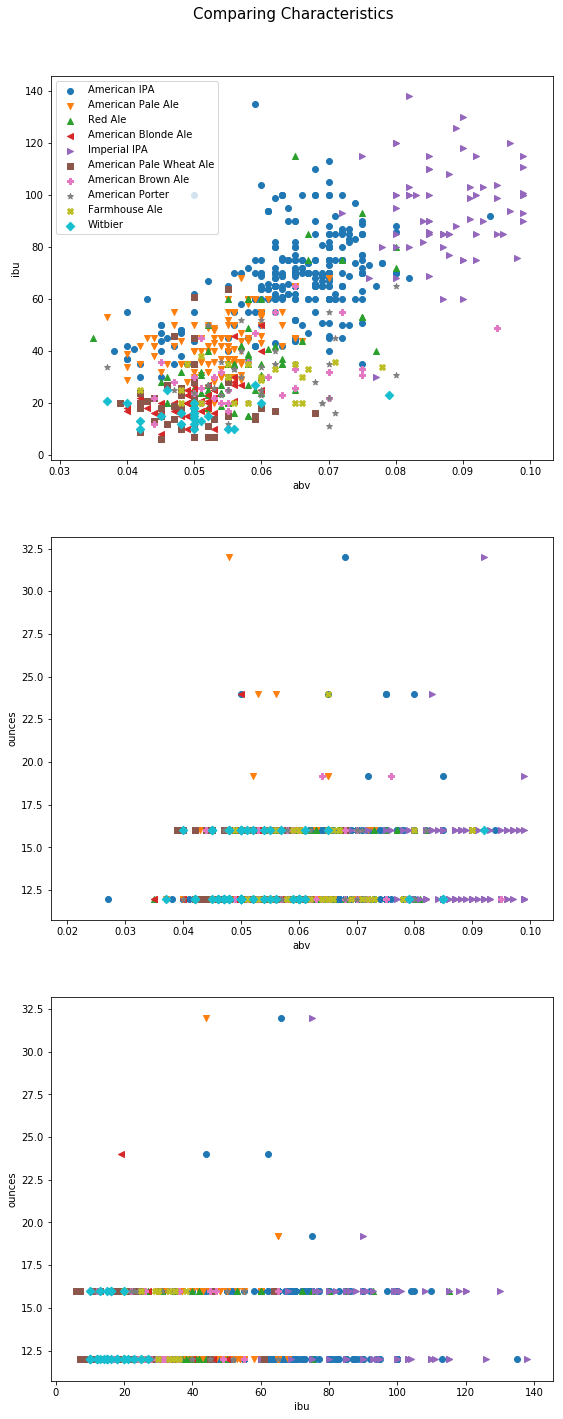

In [7]:
# plots comparing the different characteristics of the beers
def comparePlots(classes, categories, subplot_dim, names, title):
    fig = plt.figure(figsize=(9,24))
    markers = ['o','v','^','<','>','s','P','*','X','D']
    l = len(names)
    cnt = 1
    for i in range(l):
        for j in range(i,l):
            if i != j:
                x_axis = names[i]
                y_axis = names[j]
                axis_num = int(subplot_dim + str(cnt))
                plt.subplot(axis_num, 
                            label = x_axis+y_axis, 
                            frame_on = True)
                m = 0
                for c in range(len(classes)):
                    plt.scatter(classes[c][x_axis],
                             classes[c][y_axis],
                             label = categories[c],
                             marker = markers[m])
                    m+=1
                plt.xlabel(x_axis)
                plt.ylabel(y_axis)
                if cnt == 1:
                    plt.legend()
                cnt += 1
    fig.suptitle(title, fontsize=15, y=0.92)
    plt.show()

# inputs: class data sets, unique beer styles, subplot dimensions, X columns, title
comparePlots(class_sets, beer_styles, "31", columns[:-1], 'Comparing Characteristics')

In [8]:
# =============================================================================
# Data manipulation for classifier
# =============================================================================

# numbering beer styles 
def labels2ints(arr, dic):
    arr2 = []
    for i in arr:
        arr2.append(dic[i])
    return arr2

# seperating the data into test/train and X/y
def manipulateData(df, validate_size):
    vals = df.values
    X = vals[:,0:-1] # [ categories ]
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    y = vals[:,-1]   # [ class ]
    labels = np.unique(y)
    D = dict()
    for i in range(len(labels)):
        D[labels[i]] = i
    y = labels2ints(y, D)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=validate_size,random_state=seed)
    return [X_train, X_test], [y_train, y_test]

# 20% of the data will be used for testing
X, y = manipulateData(df, 0.2)

In [9]:
# =============================================================================
# Building classifier
# =============================================================================

classifier = Sequential()
classifier.add(Dense(8, 
                     name = "layer_1",
                     activation = 'relu', 
                     input_dim = num_cols))
classifier.add(Dense(16, 
                     name = "layer_2",
                     activation = 'relu'))
classifier.add(Dense(32, 
                     name = "layer_3",
                     activation = 'relu'))
classifier.add(Dense(64, 
                     name = "layer_4",
                     activation = 'relu'))
classifier.add(Dense(128, 
                     name = "layer_5",
                     activation = 'relu'))
classifier.add(Dense(num_classes, 
                     name = "layer_out",
                     activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# compile the model
classifier.compile(optimizer='nadam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [11]:
# converted labels to integers, now converted to elementary vectors
def intstoLabels(y, num_classes):
    labels = to_categorical(y, num_classes = num_classes)
    return labels

In [12]:
# training classifier
train = classifier.fit(X[0],
                       intstoLabels(y[0],num_classes),
                       epochs = epoch_num,
                       batch_size = batch_size,
                       verbose = 0)

Instructions for updating:
Use tf.cast instead.


In [13]:
# testing classifier
test = classifier.evaluate(X[1],
                           intstoLabels(y[1],num_classes),
                           batch_size = batch_size)

print("Model accuracy: {0:.2f}%".format(test[1]*100))

171/171 [==============================] - 0s 459us/step
Model accuracy: 61.40%


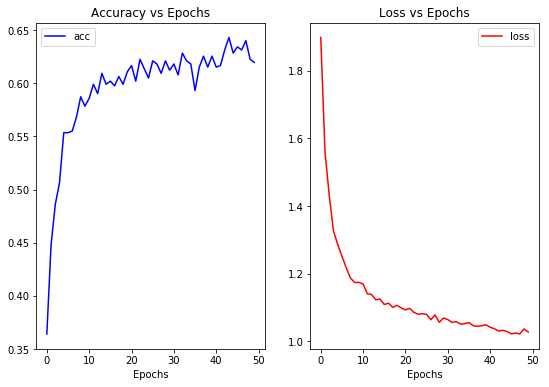

In [14]:
# evaluating model by number of epochs

def evaluateEpochs(train,test):
    plt.figure(figsize=(9,6))
    plt.subplot(121)
    plt.plot([i for i in range(epoch_num)],train.history['acc'], label = 'acc', color = 'b')
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(122)
    plt.plot([i for i in range(epoch_num)],train.history['loss'], label = 'loss', color = 'r')
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    
evaluateEpochs(train, test)